In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
!pip install -U scikit-learn

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [133]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [134]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [135]:
df['LogPassengers'] = np.log(df['Passengers'])

In [136]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [137]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogPassengers'].to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T] # using {x[t],x[t+1],...,x[t+T-1]} to predict x[t+T] i.e, one step forecast using T "true past values"
  Y.append(y)

# X is a list of lists with each list of size 10. We reshape X so that each list of size 10 is now one row
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (134, 10) Y.shape (134,)


In [138]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [139]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9599443783339897

In [140]:
lr.score(Xtest, Ytest)

0.6910953044565584

In [141]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable. This ensures that number of "True" in train_idx equals len(Xtrain)

In [142]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

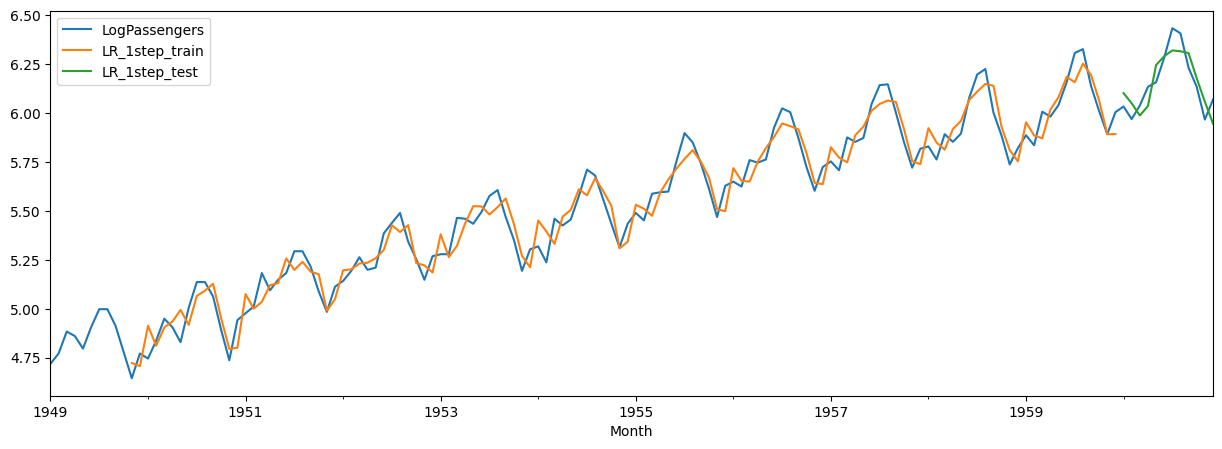

In [143]:
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

In [144]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0] # If we have data x1,x2,..xt , then last row of training will be [[x(t-T),x(t-2),x(t-1)]: x(t)] and first row of test
# will be [[x(t-T+1),x(t-1),x(t)]:x(t+1)]. Since we "have the data x1,x2,..xt available", so our starting point for multi-step forecast
# is Xtest[0] or [x(t-T+1),x(t-1),x(t)]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) # discarding oldest entry in row and appending newest forecast
  last_x[-1] = p

In [145]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

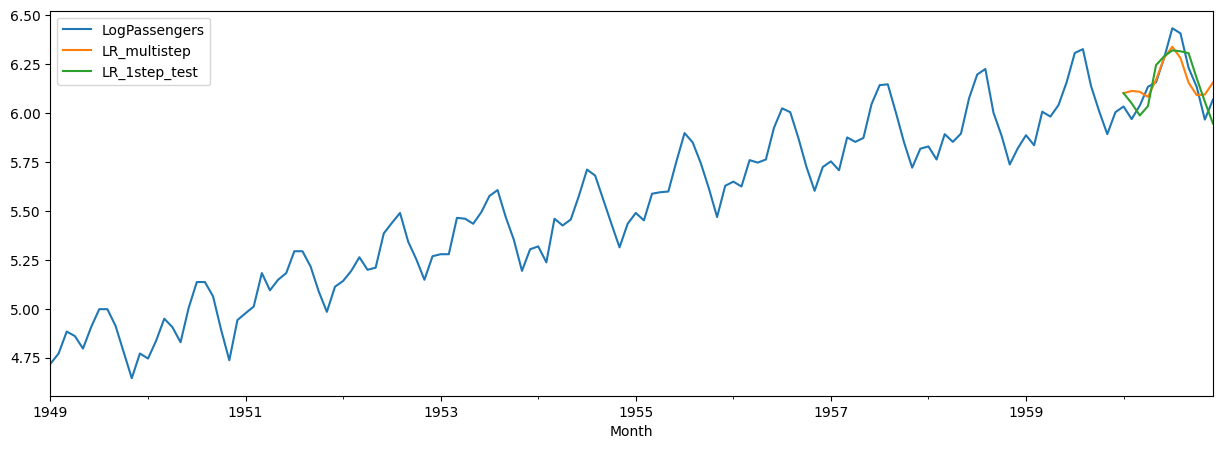

In [146]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [147]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [148]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [149]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m) # High rsquare is misleading here because we use (x1,x2,..,x10) to predict (x11,x12,...x22) and
# then (x2,..,x11) to predict (x12,...x22,x23) and so on ....so values in tuples on both left and right are repeating

0.9734607773512526

In [150]:
# SST is zero!
lr.score(Xtest_m, Ytest_m) # we get NAN because there is ONLY ONE TARGET POINT (of size Ntest)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [151]:
r2_score(Ytest_m.flatten(), lr.predict(Xtest_m).flatten()) # we flatten the multi-dimensional single target of size Ntest into
# Ntest one-dimensional targets so that we can calculate r square

0.8647994522904291

In [152]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

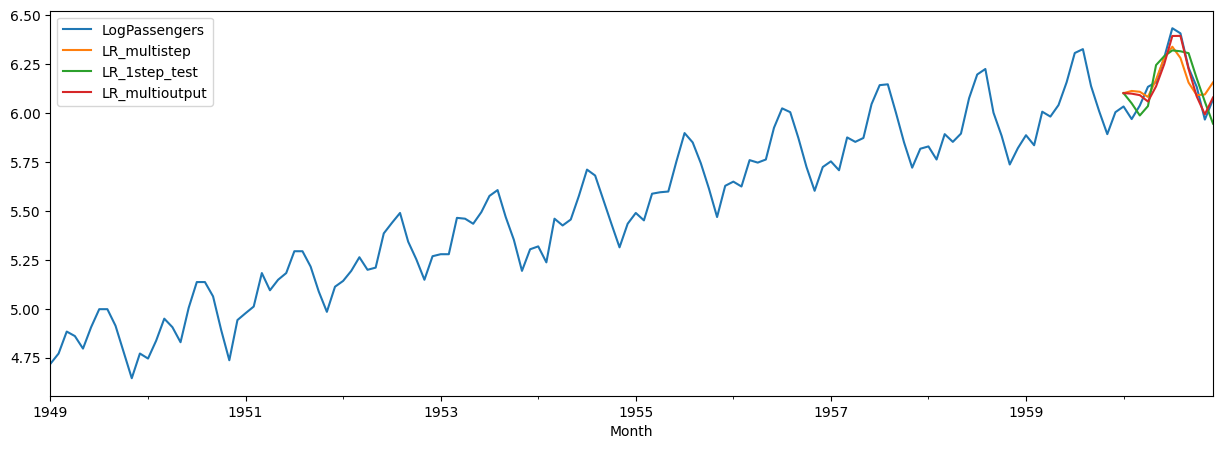

In [153]:
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [154]:
# MAPE
# Note that in case of multi-step forecast, on every subsequent step we use ADDITIONAL PREDICTED DATA to MAKE FURTHER FORECASTS
# whereas in case of multi-output forecast, we use TRUE DATA (last row) to MAKE A SINGLE MULTI-OUTPUT (next Ntest time steps) FORECAST
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.012229325023475304
multi-output MAPE: 0.007178924475039778


In [155]:
# Test Other Models

In [156]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.017529446164230467


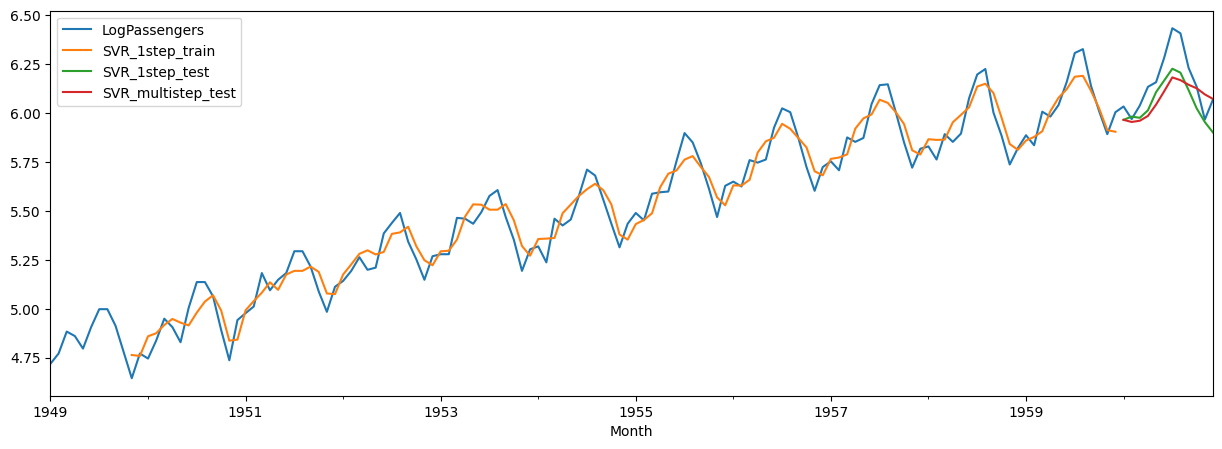

In [157]:
one_step_and_multistep_forecast(SVR(), "SVR") # SVR doesn't predict well but this data is NON-DIFFERENCED, trending & non-stationary

One-step forecast: RF
Test MAPE (multi-step): 0.028807101052249057


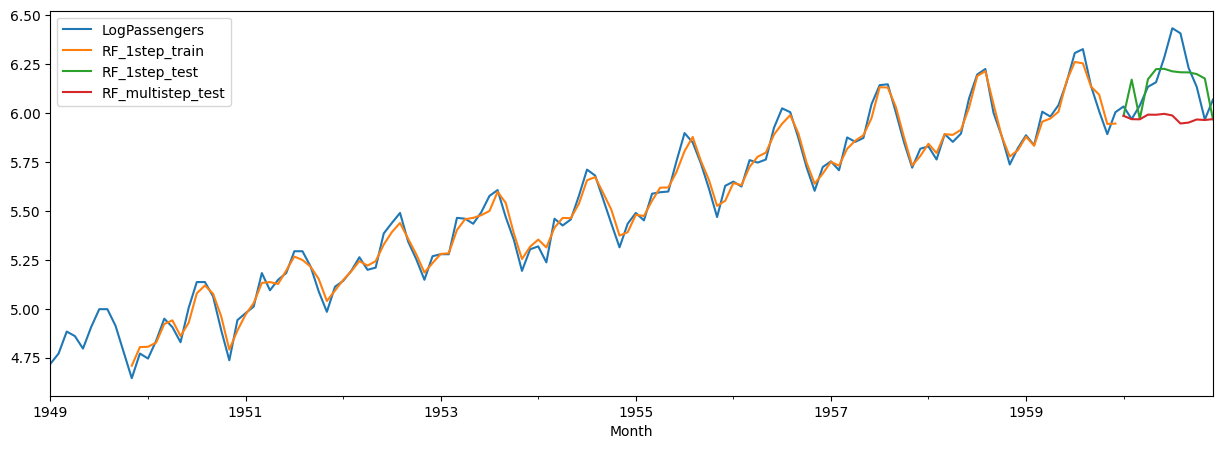

In [158]:
# Random Forest fits in-sample in terms of LINES and HYPERPLANES and fits in-sample almost perfectly if in-sample points
# don't belong to opposing classes
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [159]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [160]:
multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!
# But: you can still train multiple separate SVRs

ValueError: y should be a 1d array, got an array of shape (122, 12) instead.

Test MAPE (multi-output): 0.017172173753802204


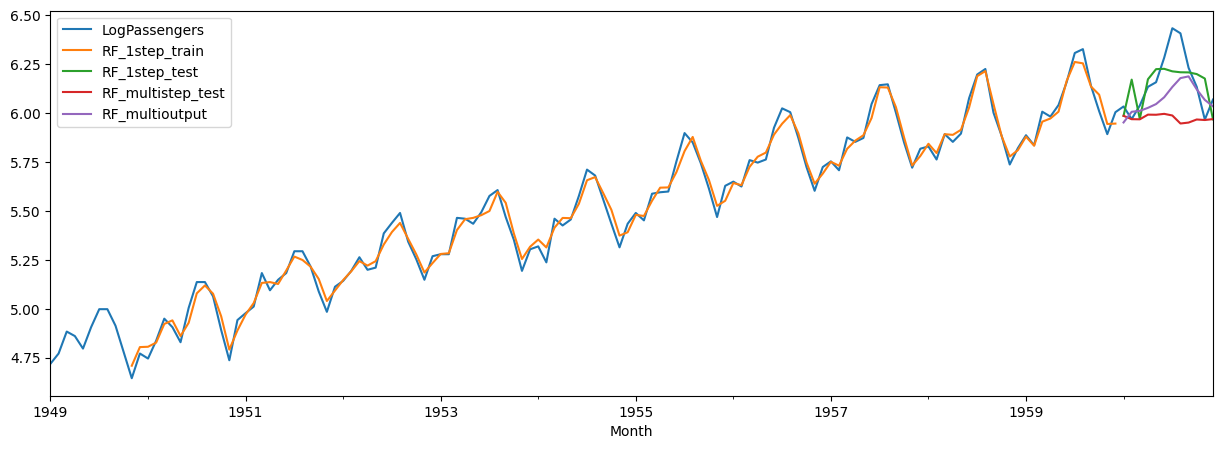

In [161]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)